In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

## Step - 1) Smoothing the Image

In [2]:
def convolve(inImg, inKernel):
  wSize = int(2 * (inKernel.shape[0]//2)) #padding size
  imgPad = np.pad(inImg, pad_width = wSize, mode='linear_ramp', end_values = 0)
  res = np.zeros(inImg.shape)
  for i in range(inImg.shape[0]):
    for j in range(inImg.shape[1]):
      res[i, j] = np.sum(inKernel * imgPad[i:i+inKernel.shape[0], j:j+inKernel.shape[0]])
  return res

In [3]:
def CEDSmooth(inImg):
  """
  This function smoothens the image, helping to remove random noise present, 
  this noise may have interfered during edge calculation, as we use first order derivative approximation
  and noise would lead to false peaks in the derivatives/gradients
  """  
  B = [
    [2, 4, 5, 4, 2],
    [4, 9, 12, 9, 4],
    [5, 10, 15, 12, 5],
    [4, 9, 12, 9, 4],
    [2, 4, 5, 4, 2]
  ]
  B = np.array(B)
  B = B/159
  inImg = convolve(inImg, B)
  return inImg

## Step - 2) Finding the Gradients

In [4]:
def CEDGrads(inImg):
  """
  This function applies sobel operators in x and y direction
  and returns the euclidean sum of the gradients in x and y, the strength of edge
  along with the angle, the direction of the edge
  """
  Kgx = np.array([[-1, 0, 1],
                 [-2, 0, 2],
                 [-1, 0, 1]])
  Kgy = np.array([[1, 2, 1],
                 [0, 0, 0],
                 [-1, -2, -1]])  
  Gx = convolve(inImg, Kgx)
  Gy = convolve(inImg, Kgy)
  G = np.sqrt(Gx**2 + Gy**2)
  theta = np.arctan(Gy/(Gx + 1e-9)) # adding small positive quantity in denominator to avoid division by 0
  return G, theta

## Step - 3) Non-Maximum Supression

In [5]:
def getDirection(theta):
  """
  This function returns direction code corresponding to angle
  0 : E/W
  1:  N/S
  2:  NW/SE
  3:  NE/SW
  """
  if(abs(theta)<np.pi/8):
    return 0
  if(abs(theta)<(np.pi/4 + np.pi/8)):
    if(theta > 0):
      return 2
    else:
      return 3
  else:
    return 1

In [6]:
def CEDNonMaxSup(imGrad, img):
  nmsImg = img.copy()
  for i in range(1, img.shape[0] - 1):
    for j in range(1, img.shape[1] - 1):
      direction = getDirection(imGrad[i, j])
      if(direction == 0):
        if(img[i, j] <= max(img[i, j-1], img[i, j+1])):
          nmsImg[i, j] = 0.0
      elif(direction == 1):
        if(img[i, j] <= max(img[i-1, j], img[i+1, j])):
          nmsImg[i, j] = 0.0
      elif(direction == 2):
        if(img[i, j] <= max(img[i-1, j+1], img[i+1, j-1])):
          nmsImg[i, j] = 0.0
      elif(direction == 3):
        if(img[i, j] <= max(img[i-1, j-1], img[i+1, j+1])):
          nmsImg[i, j] = 0.0
  return nmsImg

## Step - 4) Double Thresholding

In [7]:
def CEDHysteris(inImg, low = 0.05, high = 0.15):
  imgH = inImg.copy()
  for i in range(inImg.shape[0]):
    for j in range(inImg.shape[1]):
      if(imgH[i, j] > high):
        imgH[i, j] = 1.0
      elif(imgH[i, j] < low):
        imgH[i, j] = 0        
  return imgH

## Step - 5) Edge Tracking

In [8]:
def CEDEdgeTracking(imH1, low = 0.05, high = 0.15):
  """
  The threshold is fractional as I have converted images to float format
  The values of threshold were decided empirically
  This function returns 3 matrices,
  1)The true edge matrix, edges with intensity > high
  2)The blue edge matrix, weak edges connected to strong edges
  3)The red edge matrix, weak edges not connected to strong edges
  """
  def extend(i, j, imH):    
    if(j-1>=0 and imH[i][j-1]<=high and imH[i][j-1]>=low):
      imH[i][j-1] = 1.0
      imB[i][j-1] = 1.0
      extend(i, j-1, imH)
    if(j+1<imH.shape[1] and imH[i][j+1]<=high and imH[i][j+1]>=low)  :
      imH[i][j+1] = 1.0
      imB[i][j+1] = 1.0
      extend(i, j+1, imH)
    
    if(i-1>=0 and imH[i-1][j]<=high and imH[i-1][j]>=low):
      imH[i-1][j] = 1.0
      imB[i-1][j] = 1.0
      extend(i-1, j, imH)
    if(i+1<imH.shape[0] and imH[i+1][j]<=high and imH[i+1][j]>=low):
      imH[i+1][j] = 1.0
      imB[i+1][j] = 1.0
      extend(i+1, j, imH)
    
    if(i-1>=0 and j+1<imH.shape[1] and imH[i-1][j+1]<=high and imH[i-1][j+1]>=low):
      imH[i-1][j+1] = 1.0
      imB[i-1][j+1] = 1.0
      extend(i-1, j+1, imH)
    if(i+1<imH.shape[0] and j-1>=0 and imH[i+1][j-1]<=high and imH[i+1][j-1]>=low):
      imH[i+1][j-1] = 1.0
      imB[i+1][j-1] = 1.0
      extend(i+1, j-1, imH)
    
    if(i+1<imH.shape[0] and j+1<imH.shape[1] and imH[i+1][j+1]<=high and imH[i+1][j+1]>=low):
      imH[i+1][j+1] = 1.0
      imB[i+1][j+1] = 1.0
      extend(i+1, j+1, imH)
    if(i-1>=0 and j-1>=0 and imH[i-1][j-1]<=high and imH[i-1][j-1]>=low):
      imH[i-1][j-1] = 1.0
      imB[i-1][j-1] = 1.0
      extend(i-1, j-1, imH)
    return  
  imH = imH1.copy()
  imB = np.zeros((imH.shape[0], imH.shape[1]), dtype = 'float')
  imR = np.zeros((imH.shape[0], imH.shape[1]), dtype = 'float')
  for i in range(imH.shape[0]):
    for j in range(imH.shape[1]):
      if(imH[i, j] > high):
        extend(i, j, imH)
  for i in range(imH.shape[0]):
    for j in range(imH.shape[1]):
      if(imH[i, j]<=high and imH[i, j]>=low):                
        imH[i, j] = 0   
        imR[i, j] = 1
  return imH, imB, imR

## Step-6) Canny Module

In [9]:
def Canny(inImg, low = 0.05, high = 0.15):
  img1 = inImg.copy()
  img1 = np.array(img1, dtype = 'float') # image is converted to float type
  img1 = img1/255 # the image intensity values were normalized, to avoid overflow during sobel operation
  
  #Smoothing img, removing noise
  imgSmooth = CEDSmooth(img1)
  
  #Getting Edges Using Sobel
  imageR, imageG = CEDGrads(imgSmooth)
  
  #Non-Maximum Supression
  nms_img = CEDNonMaxSup(imageG, imageR)
  
  #Double Thresholding
  imgH1 = CEDHysteris(nms_img, low = low, high = high)
  
  #Edge Tracking
  imgH2, imgB, imgR = CEDEdgeTracking(imgH1, low = low, high = high)  
  return img1, imgSmooth, imageR, imageG, nms_img, imgH1, imgH2, imgB, imgR

## Step - 7) Final Testing Module

In [10]:
def TestCanny(img_path):
  """
  High and Low Thresholds decided empirically
  """
  #loading img1
  img1 = cv2.imread(img_path, 0)
  #img1 is normalized image after converting to float
  #imgSmooth is smoothened image
  #imageR is resultant gradient image
  #imageG is angle of the gradient
  #nms_img is image after non maximum supression
  #imgH1 is img after thresholding
  #imgH2 is img after hysteresis
  #imgB is img of weak pixels connected to strong edged
  #imgR is img of weak pixels not connected to strong edged
  img1, imgSmooth, imageR, imageG, nms_img, imgH1, imgH2, imgB, imgR = Canny(img1, low = 0.05, high = 0.15)
  
  fig1, ax1 = plt.subplots(1, 4, figsize = (15, 15))
  fig2, ax2 = plt.subplots(1, 3, figsize = (15, 15))
  ax1[0].imshow(img1, cmap = 'gray')
  ax1[0].set_title('Original Image')
  ax1[1].imshow(imgSmooth, cmap = 'gray')
  ax1[1].set_title('Smoothened Image')
  ax1[2].imshow(imageR, cmap = 'gray')
  ax1[2].set_title('Gradient Magnitudes')
  ax1[3].imshow(nms_img, cmap = 'gray')
  ax1[3].set_title('Edges after \n Non Maximum Supression')  
  ax1[0].axis('off')
  ax1[1].axis('off')
  ax1[2].axis('off')
  ax1[3].axis('off')  
  fig1.tight_layout()

  ax2[0].imshow(imgH1, cmap = 'gray')
  ax2[0].set_title('Double Thresholding')
  blank_channel = np.zeros(imgH2.shape)
  rgbimg = cv2.merge((imgR, blank_channel, imgB))
  ax2[1].imshow(imgH2, cmap = 'gray')  
  ax2[1].imshow(rgbimg, alpha=0.5)
  ax2[1].set_title('Edge Tracking By Hysteresis')
  ax2[2].imshow(imgH2, cmap = 'gray')  
  ax2[2].set_title('Final Output')
  ax2[0].axis('off')
  ax2[1].axis('off')
  ax2[2].axis('off')  
  fig2.tight_layout()  
  plt.show()

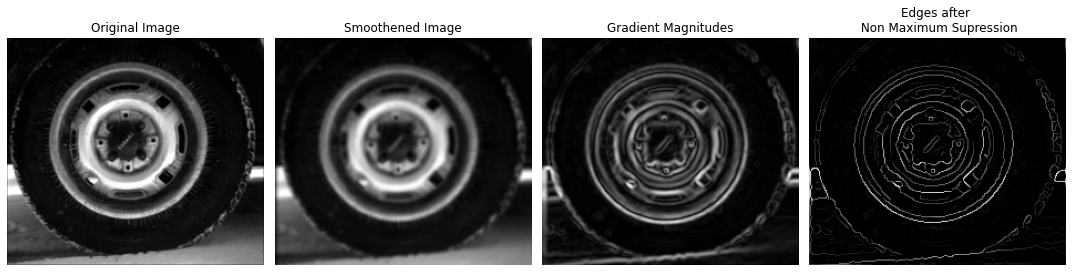

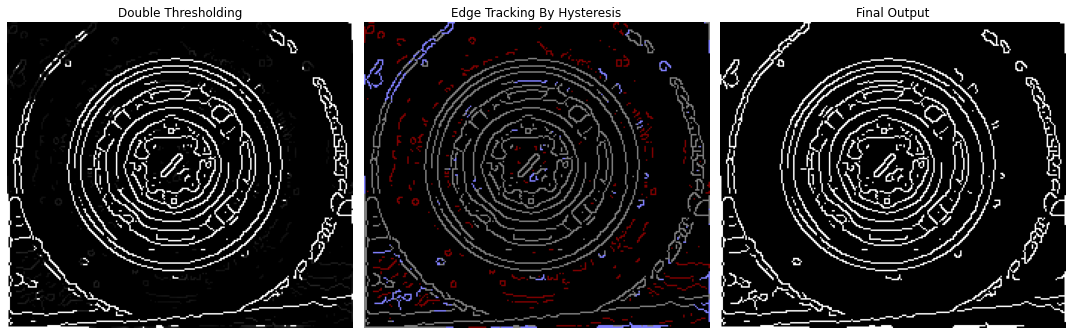

In [11]:
TestCanny('tire.tif')

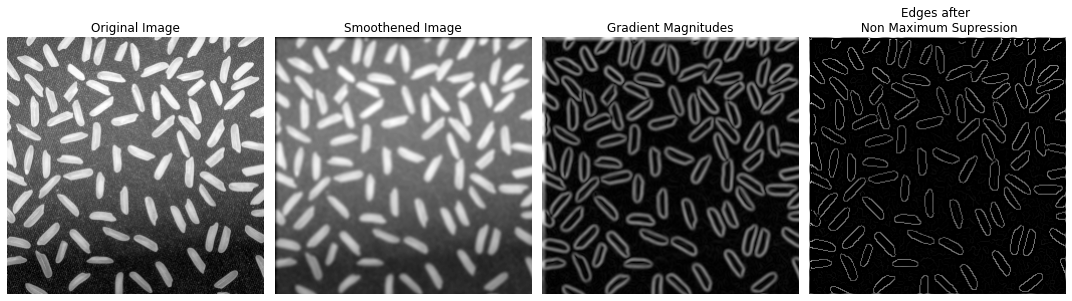

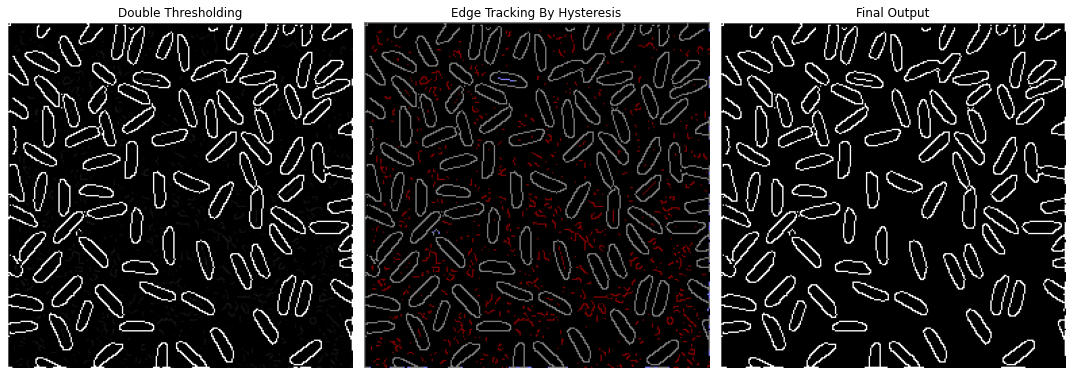

In [12]:
TestCanny('rice.png')